# ECE 657A ASSIGNMENT 2
## Covid Dataset

###### Jubilee Imhanzenobe and Olohireme Ajayi

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# defining function for plotting correlation heatmap
def plot_heatmap(correlation, title):
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(correlation,annot=True,fmt='.3f',linewidths=0.3,annot_kws={"size": 18})
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.title(title, fontsize=20)
    ax.figure.axes[-1].tick_params(labelsize=18) # To increase fontsize of colorbar ticks
    #lim = len(correlation.columns)
    #ax.set_ylim([0,lim]) # to make the map display correctly without trimming the edges
    plt.show()
    return

In [3]:
# importing the dataset
dataset = pd.read_csv('covid_train.csv')

In [4]:
dataset.head(5)

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


## Data Cleaning

In [5]:
# checking for missing values in columns
for column in dataset.columns:
    print(column, "-", dataset[column].isna().sum())

Age_Group - 6
Client_Gender - 0
Case_AcquisitionInfo - 0
Reporting_PHU_City - 0
Outbreak_Related - 9020
Reporting_PHU_Latitude - 0
Reporting_PHU_Longitude - 0
Outcome1 - 0


In [6]:
# filling missing values in outbreak related with NO
dataset["Outbreak_Related"].fillna("No", inplace=True)

# drop missing columns in Age_Group
dataset.dropna(axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [7]:
# grouping features accourding to their data types
cats = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']
nums = ['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
ords = ['Age_Group']
target = ['Outcome1']

In [8]:
# inspecting the unique values in categorical columns and their frequencies
for column in cats:
    print(column)
    print(dataset[column].value_counts())
    print()

Client_Gender
FEMALE            7496
MALE              7243
UNSPECIFIED        104
GENDER DIVERSE       2
Name: Client_Gender, dtype: int64

Case_AcquisitionInfo
OB                      5387
CC                      4114
MISSING INFORMATION     2952
NO KNOWN EPI LINK       2189
TRAVEL                   199
UNSPECIFIED EPI LINK       4
Name: Case_AcquisitionInfo, dtype: int64

Reporting_PHU_City
Toronto             5158
Mississauga         2516
Newmarket           1193
Ottawa               789
Whitby               598
Windsor              581
Thorold              567
Hamilton             505
Oakville             456
Waterloo             450
London               361
Barrie               361
Guelph               259
Cornwall             152
St. Thomas           111
Point Edward          83
Thunder Bay           81
Simcoe                81
Port Hope             78
Stratford             70
Brantford             70
Brockville            61
Chatham               60
Sudbury               53
Tim

In [9]:
# Assigning numeric labels to ordinal data for data exploration
dataset['Age_Group'].replace(["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],[0,1,2,3,4,5,6,7,8], inplace = True)

In [10]:
# Label encoding the outcomes
dataset['Outcome1'].replace(["Resolved", "Not Resolved", "Fatal"],[0,1,2], inplace = True)

## Exploratrory Data Analysis

##### Plotting the pairs plot for numeric features

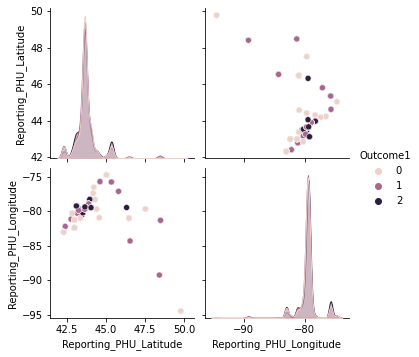

In [11]:
sns.pairplot(dataset[['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1']], hue="Outcome1")

#### Checking the correlation for numerical features

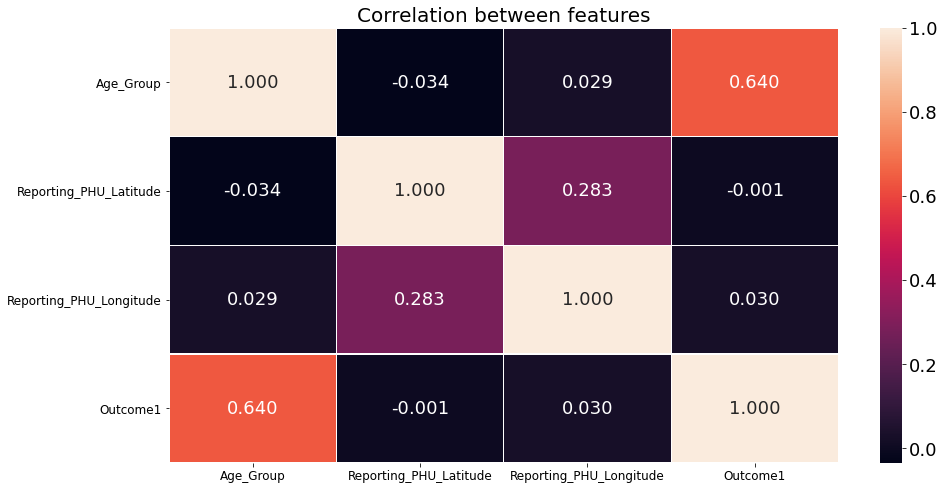

In [12]:
plot_heatmap(dataset.corr(), 'Correlation between features')

### <span style="color:blue">Observations from correlation heatmap of numeric and ordinal features </span> 

- Age group has the highest positive correlation with the outcome (0.640)
- latitude and longitude have low correlation with the outcome.

### Checking the correlations of categorical features using Cramer's V method

Cramér’s V is substitute for correlation which is suitable for categorical variables. It is based on a nominal variation of Pearson’s Chi-Square Test.

1. Just like correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t).

2. Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

In [13]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [14]:
for column1 in cats:
    print(column1, '-', 'Outcome = ', round(cramers_v(dataset[column1], dataset['Outcome1']), 3))
    for column2 in cats:
        print(column1, '-', column2, '=', round(cramers_v(dataset[column1], dataset[column2]), 3))
    print()

Client_Gender - Outcome =  0.011
Client_Gender - Client_Gender = 1.0
Client_Gender - Case_AcquisitionInfo = 0.06
Client_Gender - Reporting_PHU_City = 0.074
Client_Gender - Outbreak_Related = 0.107

Case_AcquisitionInfo - Outcome =  0.419
Case_AcquisitionInfo - Client_Gender = 0.06
Case_AcquisitionInfo - Case_AcquisitionInfo = 1.0
Case_AcquisitionInfo - Reporting_PHU_City = 0.262
Case_AcquisitionInfo - Outbreak_Related = 0.918

Reporting_PHU_City - Outcome =  0.147
Reporting_PHU_City - Client_Gender = 0.074
Reporting_PHU_City - Case_AcquisitionInfo = 0.262
Reporting_PHU_City - Reporting_PHU_City = 1.0
Reporting_PHU_City - Outbreak_Related = 0.199

Outbreak_Related - Outcome =  0.527
Outbreak_Related - Client_Gender = 0.107
Outbreak_Related - Case_AcquisitionInfo = 0.918
Outbreak_Related - Reporting_PHU_City = 0.199
Outbreak_Related - Outbreak_Related = 1.0



### <span style="color:blue">Observations from Cramer's V coefficients of categorical features </span> 

- Outbreak Related has a the most significant relationship with the outcome (0.527).
- Case_AcquisitionInfo also has a significant relationship with the outcome (0.419).
- Client Gender has the least correlation with the outcome.
- Case_AcquisitionInfo and Outbreak Related have the highest inter-feature relationship (0.918) which is logical as they both describe how the virus was contacted.

##### Calculating the mean, variance, skew, kurtosis for the datasets

In [15]:
# comparing for the different outcomeget
for outcome in dataset["Outcome1"].unique():
    print("*** Outcome = ", outcome, "***")
    columns = nums + ords
    for column in columns:
        
        mean = round(dataset[dataset['Outcome1'] == outcome][column].mean(), 2)
        variance = round(dataset[dataset['Outcome1'] == outcome][column].var(), 2)
        skew = round(dataset[dataset['Outcome1'] == outcome][column].skew(), 2)
        kurtosis = round(dataset[dataset['Outcome1'] == outcome][column].kurt(), 2)
        print(column, "Mean -", mean)
        
        # if column is not numeric find the mode
        if column in cats or column in ords:
            mode = round(dataset[dataset['Outcome1'] == outcome][column].mode()[0], 2)
            print(column, "Mode -", mode)
            
        print(column, "Variance -", variance)
        print(column, "Skew -", skew)
        print(column, "Kurtosis -", kurtosis)
        print()

*** Outcome =  0 ***
Reporting_PHU_Latitude Mean - 43.73
Reporting_PHU_Latitude Variance - 0.51
Reporting_PHU_Latitude Skew - 2.6
Reporting_PHU_Latitude Kurtosis - 15.63

Reporting_PHU_Longitude Mean - -79.59
Reporting_PHU_Longitude Variance - 2.43
Reporting_PHU_Longitude Skew - -1.4
Reporting_PHU_Longitude Kurtosis - 16.62

Age_Group Mean - 2.73
Age_Group Mode - 1
Age_Group Variance - 4.12
Age_Group Skew - 0.56
Age_Group Kurtosis - -0.42

*** Outcome =  1 ***
Reporting_PHU_Latitude Mean - 43.77
Reporting_PHU_Latitude Variance - 0.65
Reporting_PHU_Latitude Skew - 3.22
Reporting_PHU_Latitude Kurtosis - 15.82

Reporting_PHU_Longitude Mean - -79.63
Reporting_PHU_Longitude Variance - 2.58
Reporting_PHU_Longitude Skew - -2.11
Reporting_PHU_Longitude Kurtosis - 18.9

Age_Group Mean - 2.95
Age_Group Mode - 1
Age_Group Variance - 4.45
Age_Group Skew - 0.49
Age_Group Kurtosis - -0.59

*** Outcome =  2 ***
Reporting_PHU_Latitude Mean - 43.72
Reporting_PHU_Latitude Variance - 0.54
Reporting_PHU_L

###  <span style="color:blue"> Nature of the data and observations </span>

- The most frequently occuring age group in the Resolved and Not Resolved Outcomes is 20s, while the mode age group for the Fatal Outcome is 80s.
- The mean latitude and longitude for all outcomes are similar.
- for all outcomes, Longitude is left skewed while Latitude is right skewed.

In [16]:
# Assigning numeric labels to categorical data for data exploration
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data = dataset.copy()
for column in cats:
    data[column] = le.fit_transform(data[column])

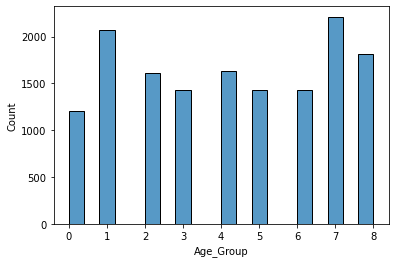

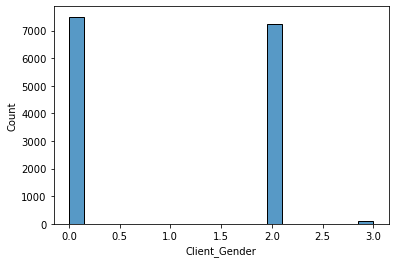

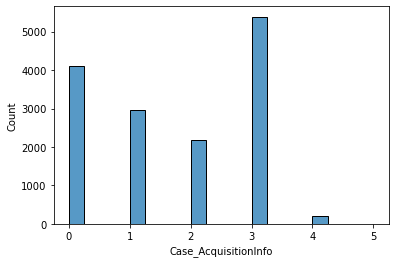

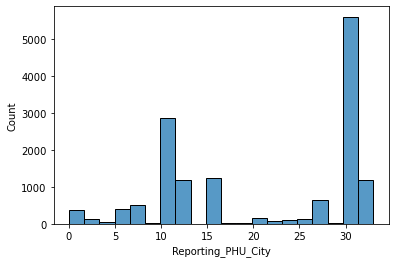

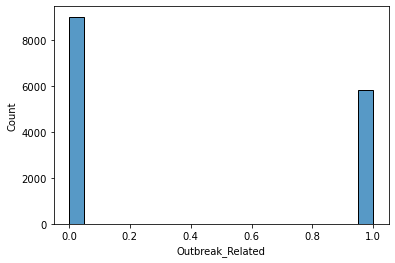

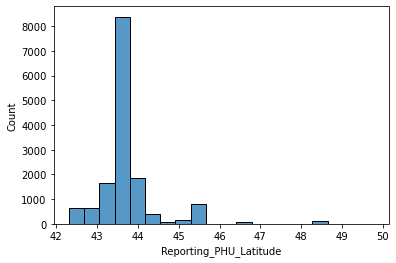

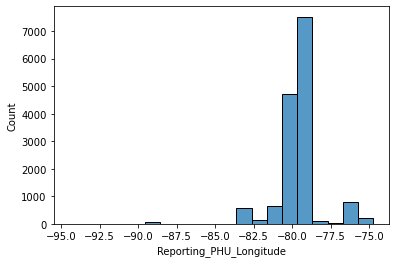

In [17]:
# Plotting histogram to view data distribution
for column in data.iloc[:,:-1].columns:
    plt.figure()
    sns.histplot(data = data, x = column, bins = 20)
    plt.show()

### <span style="color:blue">Notes about Histogram</span>

- All categorical variables are in the right range without outliers.
- Reporting_PHU_Latitude and Reporting_PHU_Longitude both seem to have outliers.

#### Plotting histogram grouped by the different outcomes

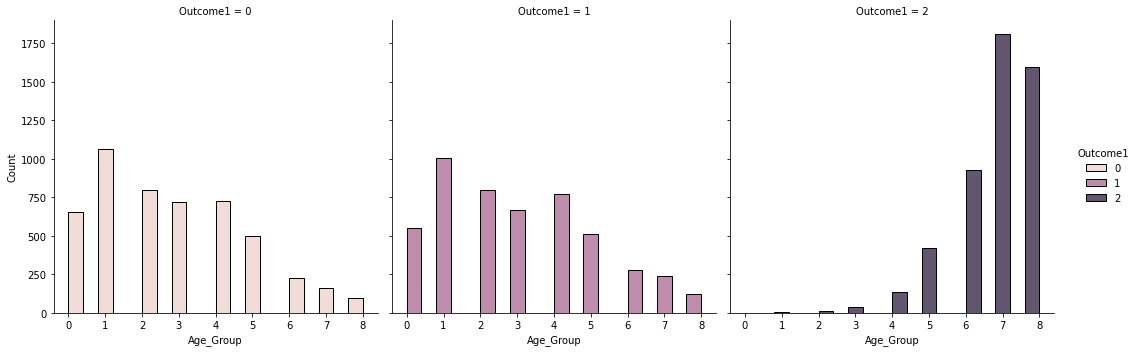

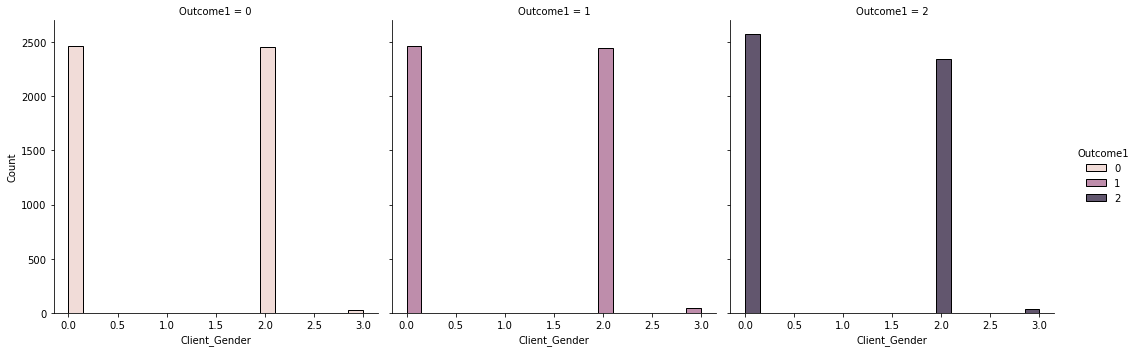

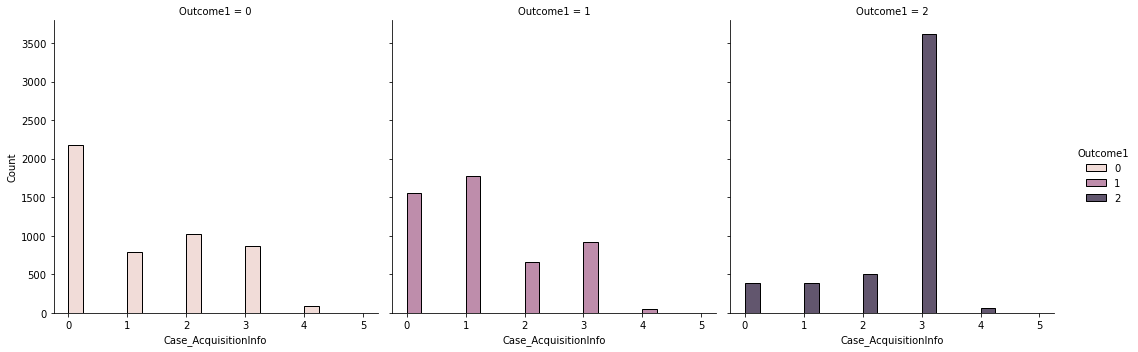

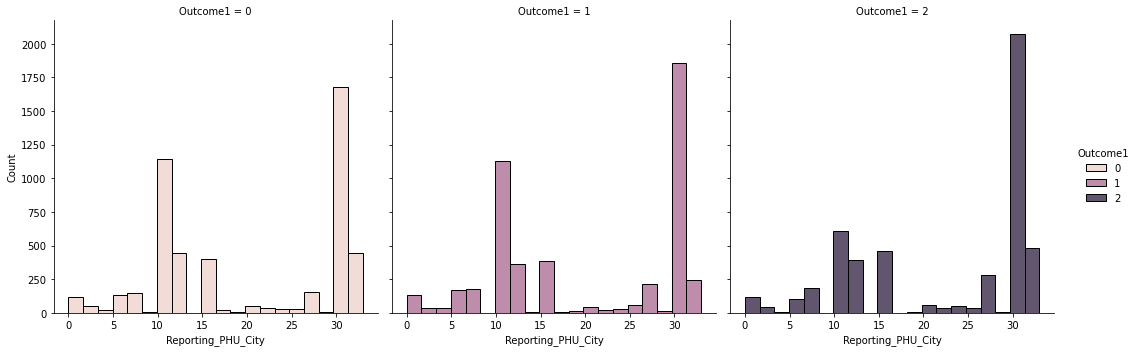

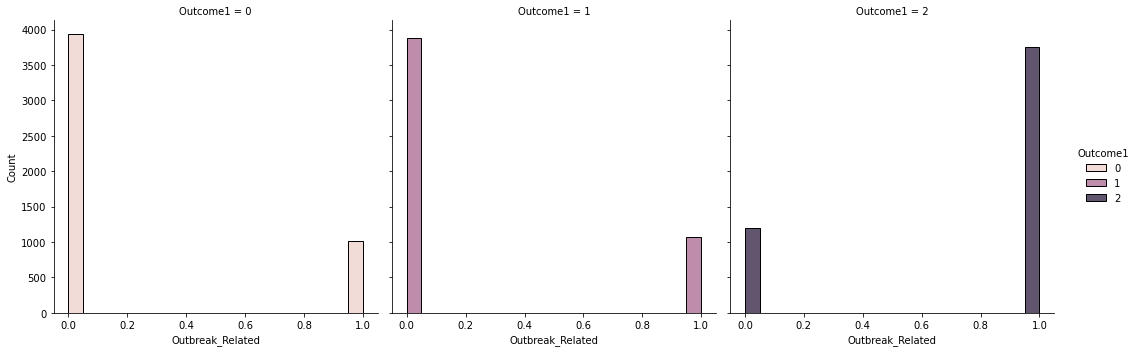

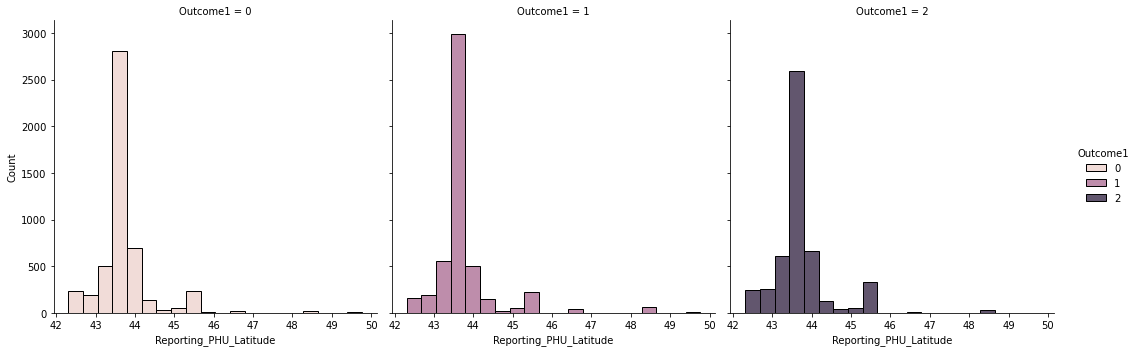

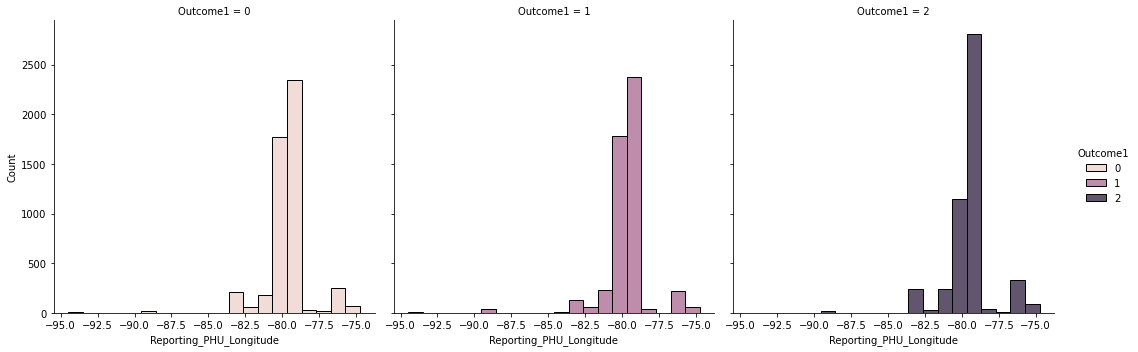

In [18]:
# plotting the histogram to view data distribution by outcome
for feature in data.columns[:-1]:
    sns.displot(data, x = feature, bins = 20, col = 'Outcome1', hue = 'Outcome1')

#### <span style="color:blue">Nature of the data and observations</span>

- For Age Group, most of people older than 70 have a fatal outcome while most people less than 40 have either Resolced or Unresolved outcomes.
- The distributions for Client Gender, Outbreak Related and Reporting_PHU_City are very similar for all three Outcomes
- In the Case Acquisition Info, most of the causes caused by outbreak resulted in a fatal outcome.
- Most cases which were outbreak related had a fatal outcome.

In [19]:
dataset.head()

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,4,MALE,NO KNOWN EPI LINK,Oakville,No,43.413997,-79.744796,0
1,1,FEMALE,CC,Guelph,No,43.524881,-80.233743,1
2,8,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,0
3,1,FEMALE,MISSING INFORMATION,Toronto,No,43.656591,-79.379358,0
4,8,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,2


In [20]:
# create a copy of dataset
data = dataset.copy()

## Data Preparation

##### One Hot Encoding the categorical features

In [21]:
df = pd.get_dummies(dataset.iloc[:,:-1], columns = cats)
df["Outcome1"] = dataset["Outcome1"]
dataset = df

dataset.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,...,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_No,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,43.524881,-80.233743,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,8,44.410713,-79.686306,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,43.656591,-79.379358,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,8,45.345665,-75.763912,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


In [22]:
dataset.shape

(14845, 50)

In [23]:
# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Building the Base Models

#### Decision Tree Classifier

In [25]:
%%time
from sklearn.tree import DecisionTreeClassifier, export_graphviz
d_tree = DecisionTreeClassifier(random_state = 0)

from sklearn.model_selection import GridSearchCV
d_tree_params = [{'max_depth':[3, 5, 10, None]}]
d_tree_grid = GridSearchCV(d_tree, d_tree_params, cv=10)
d_tree_grid.fit(X_train, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

Wall time: 1.63 s


DecisionTreeClassifier(max_depth=5, random_state=0)

In [26]:
d_tree_average_score

array([0.6521587 , 0.65763157, 0.65721076, 0.64306304])

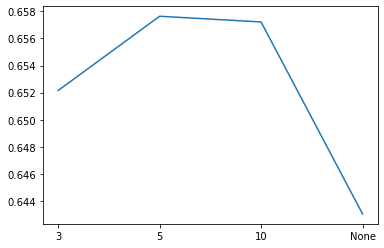

In [27]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

In [28]:
# Building the model with optimal parameters
d_tree = DecisionTreeClassifier(max_depth=5, random_state=0)
d_tree.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, d_tree.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  66.25


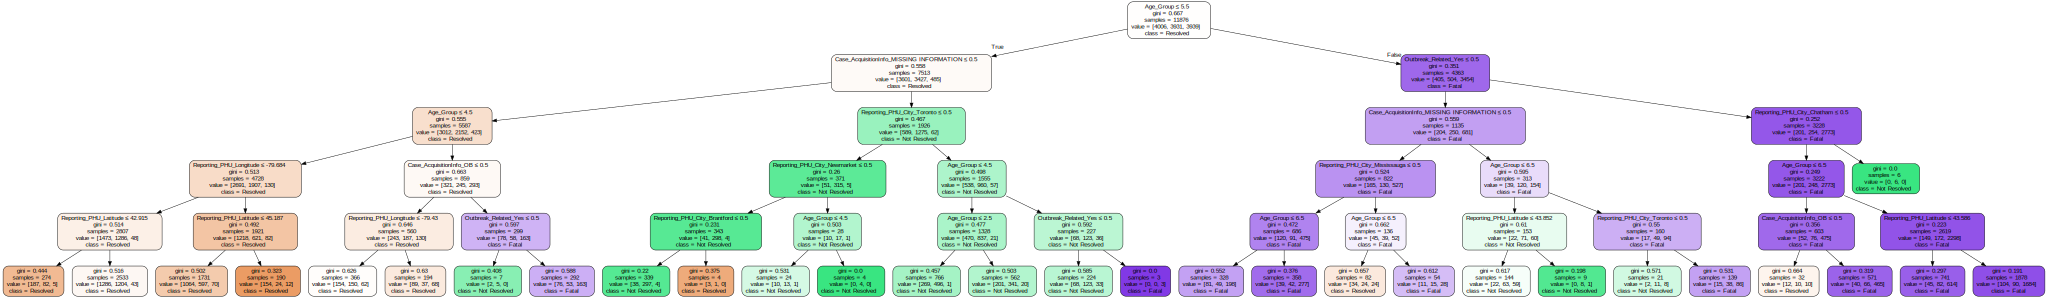

In [29]:
# Visualizing the decision tree
import graphviz
dot_data = export_graphviz(d_tree, 
                  feature_names=dataset.columns[:-1],
                  class_names = ["Resolved", "Not Resolved", "Fatal"],
                  filled=True, rounded=True,  
                  special_characters=True,
                  out_file=None)

graph = graphviz.Source(dot_data, format = 'png')
graph.render(filename='decision_tree_01')
graph

In [30]:
# Evaluating the model on the test set
d_tree_pred = d_tree.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, d_tree_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.81


#### Random Forest Classifier

In [31]:
%%time
from sklearn.ensemble import RandomForestClassifier
r_forest = RandomForestClassifier(random_state = 0)

r_forest_params = [{'n_estimators':[5, 10, 50, 150, 200], 'max_depth':[3, 5, 10, None]}]
r_forest_grid = GridSearchCV(r_forest, r_forest_params, cv=10)
r_forest_grid.fit(X_train, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

Wall time: 2min


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

In [32]:
r_forest_average_score

array([0.65308491, 0.64525216, 0.61763464, 0.62310837, 0.62352938,
       0.66040977, 0.66091532, 0.6393604 , 0.65459992, 0.6594847 ,
       0.66057954, 0.66546212, 0.66470504, 0.66537901, 0.66605276,
       0.64432694, 0.64912641, 0.64794782, 0.65013686, 0.65038932])

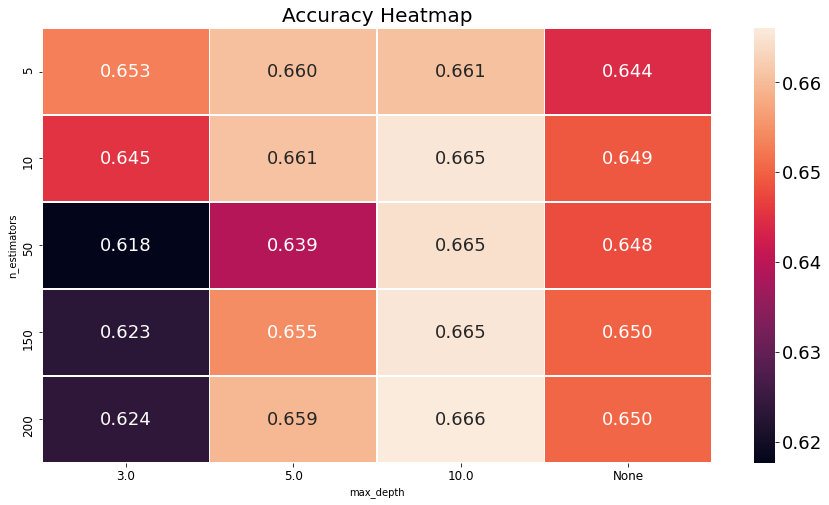

In [33]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

In [34]:
%%time
# Building model with optimal parameters
r_forest = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)
r_forest.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, r_forest.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  69.8
Wall time: 1.94 s


In [35]:
# Evaluating the model on the test set
r_forest_pred = r_forest.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, r_forest_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  67.4


#### Gradient Tree Boosting Classifier

In [36]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier(random_state = 0)

g_boost_params = [{'n_estimators':[5, 10, 50, 150, 200]}]
g_boost_grid = GridSearchCV(g_boost, g_boost_params, cv=10)
g_boost_grid.fit(X_train, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

Wall time: 3min 55s


GradientBoostingClassifier(n_estimators=150, random_state=0)

In [37]:
g_boost_average_score

array([0.65990486, 0.66074739, 0.66706293, 0.66866333, 0.66739964])

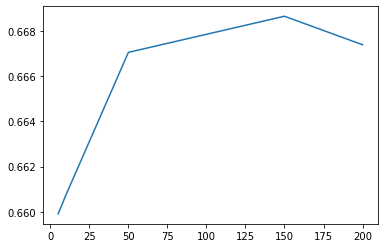

In [38]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

In [39]:
%%time
# Building model with optimal parameters
g_boost = GradientBoostingClassifier(n_estimators=150, random_state=0)
g_boost.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, g_boost.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  68.52
Wall time: 8.95 s


In [40]:
# Evaluating the model on the test set
g_boost_pred = g_boost.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, g_boost_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  67.23


## Improving Model Computation Time and Accuracy by Feature Engineering

### Method 1: Dropping the Reporting_PHU_City column

The Reporting_PHU_City column is a categorical column with 34 distinct values this means that after on hot encoding, it adds 34 features columns to the data thus making it computationally expensive.

Considering its low correlation with the outcome, we will deal with this by removing the feature from the matrix of features. This reduces the columns in the matrix of features from 49 to 15 

Also 

In [41]:
# removing the Reporting_PHU_City column
dataset2 =  data[['Age_Group', 'Client_Gender', 'Case_AcquisitionInfo',
                    'Outbreak_Related', 'Reporting_PHU_Latitude',
                   'Reporting_PHU_Longitude', 'Outcome1']]

df = pd.get_dummies(dataset2.iloc[:,:-1], drop_first=True, columns = ['Client_Gender','Case_AcquisitionInfo','Outbreak_Related'])
df["Outcome1"] = dataset2["Outcome1"]
dataset2 = df

dataset2.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,1,0,0,1,0,0,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,0,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,0,1,0,0,1,0
3,1,43.656591,-79.379358,0,0,0,1,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,0,1,0,0,1,2


In [42]:
# Separating the dataset into matrix of features and target'
X = dataset2.iloc[:,:-1].values
y = dataset2.iloc[:,-1].values

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Decision Tree Classifier

In [44]:
%%time
from sklearn.tree import DecisionTreeClassifier, export_graphviz
d_tree = DecisionTreeClassifier(random_state = 0)

from sklearn.model_selection import GridSearchCV
d_tree_params = [{'max_depth':[3, 5, 10, None]}]
d_tree_grid = GridSearchCV(d_tree, d_tree_params, cv=10)
d_tree_grid.fit(X_train, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

Wall time: 540 ms


DecisionTreeClassifier(max_depth=5, random_state=0)

In [45]:
d_tree_average_score

array([0.65182178, 0.65796827, 0.65367413, 0.64373665])

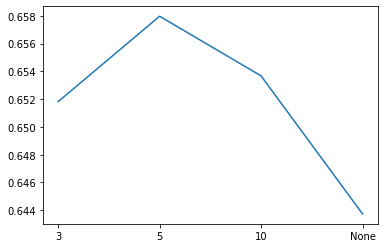

In [46]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

In [47]:
# Building the model with optimal parameters
d_tree = DecisionTreeClassifier(max_depth=5, random_state=0)
d_tree.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, d_tree.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  66.14


In [48]:
# Evaluating the model on the test set
d_tree_pred = d_tree.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, d_tree_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.91


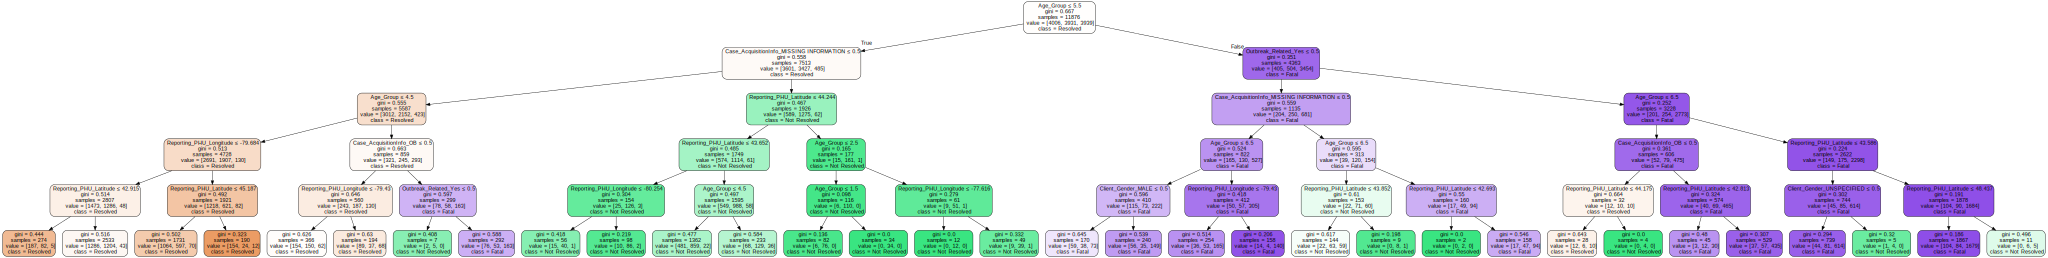

In [49]:
dot_data = export_graphviz(d_tree, 
                  feature_names=dataset2.columns[:-1],
                  class_names = ["Resolved", "Not Resolved", "Fatal"],
                  filled=True, rounded=True,  
                  special_characters=True,
                  out_file=None)

graph = graphviz.Source(dot_data, format = 'png')
graph.render(filename='decision_tree_02')
graph

#### Random Forest Classifier

In [50]:
%%time
from sklearn.ensemble import RandomForestClassifier
r_forest = RandomForestClassifier(random_state = 0)

r_forest_params = [{'n_estimators':[5, 10, 50, 150, 200], 'max_depth':[3, 5, 10, None]}]
r_forest_grid = GridSearchCV(r_forest, r_forest_params, cv=10)
r_forest_grid.fit(X_train, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

Wall time: 1min 35s


RandomForestClassifier(max_depth=5, n_estimators=150, random_state=0)

In [51]:
r_forest_average_score

array([0.62092201, 0.66057769, 0.66116841, 0.65081112, 0.6616736 ,
       0.65662132, 0.66428289, 0.66537851, 0.66563061, 0.66546254,
       0.65999053, 0.66285326, 0.66529455, 0.66453719, 0.66276887,
       0.6441588 , 0.64761062, 0.64744269, 0.64811595, 0.64929483])

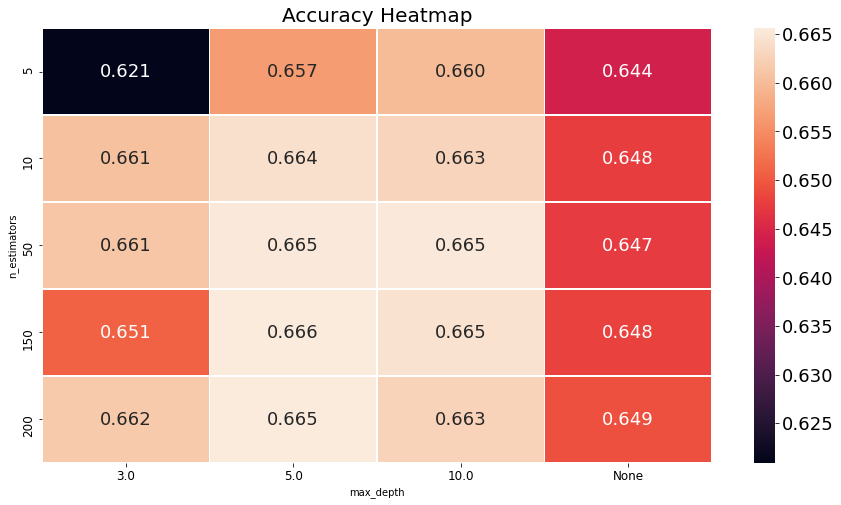

In [52]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

In [53]:
%%time
# Building model with optimal parameters
r_forest = RandomForestClassifier(max_depth=5, n_estimators=150, random_state=0)
r_forest.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, r_forest.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  66.98
Wall time: 1.03 s


In [54]:
# Evaluating the model on the test set
r_forest_pred = r_forest.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, r_forest_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  66.62


#### Gradient Tree Boosting Classifier

In [55]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier(random_state = 0)

g_boost_params = [{'n_estimators':[5, 10, 50, 150, 200]}]
g_boost_grid = GridSearchCV(g_boost, g_boost_params, cv=10)
g_boost_grid.fit(X_train, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

Wall time: 2min 1s


GradientBoostingClassifier(n_estimators=200, random_state=0)

In [56]:
g_boost_average_score

array([0.65931542, 0.65998946, 0.66377897, 0.66411645, 0.66588434])

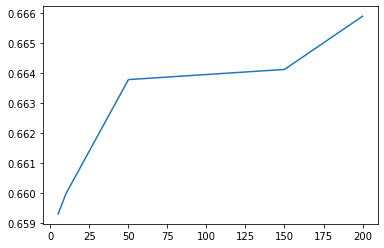

In [57]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

In [58]:
%%time
# Building model with optimal parameters
g_boost = GradientBoostingClassifier(n_estimators=200, random_state=0)
g_boost.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, g_boost.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  68.55
Wall time: 6.28 s


In [59]:
# Evaluating the model on the test set
g_boost_pred = g_boost.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, g_boost_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  67.63


### Method 2: Aggregating categories in the columns

In [60]:
# inspecting the unique values in categorical columns and their frequencies
dataset3 = data.copy()
for column in cats:
    print(column)
    print(dataset3[column].value_counts())
    print()

Client_Gender
FEMALE            7496
MALE              7243
UNSPECIFIED        104
GENDER DIVERSE       2
Name: Client_Gender, dtype: int64

Case_AcquisitionInfo
OB                      5387
CC                      4114
MISSING INFORMATION     2952
NO KNOWN EPI LINK       2189
TRAVEL                   199
UNSPECIFIED EPI LINK       4
Name: Case_AcquisitionInfo, dtype: int64

Reporting_PHU_City
Toronto             5158
Mississauga         2516
Newmarket           1193
Ottawa               789
Whitby               598
Windsor              581
Thorold              567
Hamilton             505
Oakville             456
Waterloo             450
London               361
Barrie               361
Guelph               259
Cornwall             152
St. Thomas           111
Point Edward          83
Thunder Bay           81
Simcoe                81
Port Hope             78
Stratford             70
Brantford             70
Brockville            61
Chatham               60
Sudbury               53
Tim

In the Client_Gender feature, UNSPECIFIED and GENDER DIVERSE have very low counts compared to the rest and they can both be grouped into one category OTHERS.

In the Case_AcquisitionInfo feature, TRAVEL and UNSPECIFIED EPI LINK have very low counts compared to the rest and they can both be grouped into one category OTHERS.

In the Reporting_PHU_City feature, there are 34 distince categories. Rather than dropping the entire feature, the categories can be grouped by their counts.
City_Class1 = > 500
City_Class2 = 75 to 500
City_Class3 = < 75

In [61]:
dataset3["Client_Gender"].replace(['UNSPECIFIED', 'GENDER DIVERSE'], 'OTHER', inplace = True)
dataset3["Case_AcquisitionInfo"].replace(['TRAVEL', 'UNSPECIFIED EPI LINK'], 'OTHER', inplace = True)

In [62]:
City_Class1 = list((dataset3['Reporting_PHU_City'].value_counts()[dataset3['Reporting_PHU_City'].value_counts() > 500]).index)
City_Class1

['Toronto',
 'Mississauga',
 'Newmarket',
 'Ottawa',
 'Whitby',
 'Windsor',
 'Thorold',
 'Hamilton']

In [63]:
City_Class2 = list((dataset3['Reporting_PHU_City'].value_counts()[(dataset3['Reporting_PHU_City'].value_counts() <= 500) & (dataset3['Reporting_PHU_City'].value_counts() > 75)]).index)
City_Class2

['Oakville',
 'Waterloo',
 'London',
 'Barrie',
 'Guelph',
 'Cornwall',
 'St. Thomas',
 'Point Edward',
 'Thunder Bay',
 'Simcoe',
 'Port Hope']

In [64]:
City_Class3 = list((dataset3['Reporting_PHU_City'].value_counts()[dataset3['Reporting_PHU_City'].value_counts() <= 75]).index)
City_Class3

['Stratford',
 'Brantford',
 'Brockville',
 'Chatham',
 'Sudbury',
 'Timmins',
 'Peterborough',
 'Owen Sound',
 'Belleville',
 'Kingston',
 'Kenora',
 'Pembroke',
 'Sault Ste. Marie',
 'North Bay',
 'New Liskeard']

In [65]:
dataset3["Reporting_PHU_City"].replace(City_Class1, 1, inplace = True)
dataset3["Reporting_PHU_City"].replace(City_Class2, 2, inplace = True)
dataset3["Reporting_PHU_City"].replace(City_Class3, 3, inplace = True)

In [66]:
df = pd.get_dummies(dataset3.iloc[:,:-1], drop_first=True, columns = cats)
df["Outcome1"] = dataset3["Outcome1"]
dataset3 = df

dataset3.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_OTHER,Reporting_PHU_City_2,Reporting_PHU_City_3,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,1,0,0,1,0,0,1,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,1,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,1,0,1,0,1,0
3,1,43.656591,-79.379358,0,0,1,0,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,1,0,0,0,1,2


In [67]:
# Separating the dataset into matrix of features and target'
X = dataset3.iloc[:,:-1].values
y = dataset3.iloc[:,-1].values

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Decision Tree Classifier

In [69]:
%%time
from sklearn.tree import DecisionTreeClassifier, export_graphviz
d_tree = DecisionTreeClassifier(random_state = 0)

from sklearn.model_selection import GridSearchCV
d_tree_params = [{'max_depth':[3, 5, 10, None]}]
d_tree_grid = GridSearchCV(d_tree, d_tree_params, cv=10)
d_tree_grid.fit(X_train, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

Wall time: 670 ms


DecisionTreeClassifier(max_depth=5, random_state=0)

In [70]:
d_tree_average_score

array([0.65182178, 0.65763143, 0.653506  , 0.64230539])

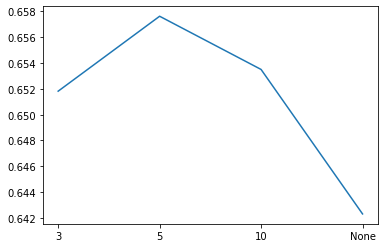

In [71]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

In [72]:
# Building the model with optimal parameters
d_tree = DecisionTreeClassifier(max_depth=5, random_state=0)
d_tree.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, d_tree.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  66.14


In [73]:
# Evaluating the model on the test set
d_tree_pred = d_tree.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, d_tree_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.91


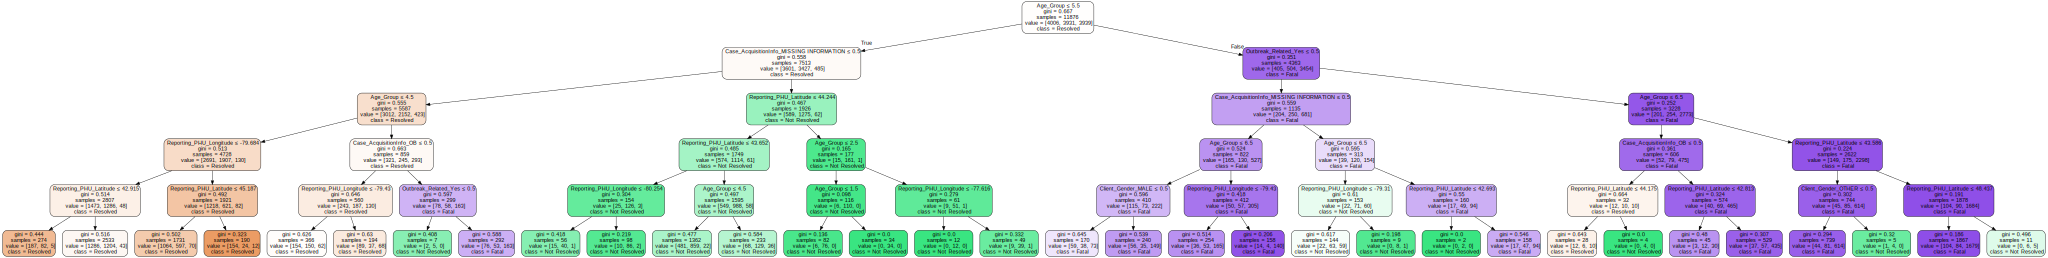

In [74]:
dot_data = export_graphviz(d_tree, 
                  feature_names=dataset3.columns[:-1],
                  class_names = ["Resolved", "Not Resolved", "Fatal"],
                  filled=True, rounded=True,  
                  special_characters=True,
                  out_file=None)

graph = graphviz.Source(dot_data, format = 'png')
graph.render(filename='decision_tree_03')
graph

#### Random Forest Classifier

In [75]:
%%time
from sklearn.ensemble import RandomForestClassifier
r_forest = RandomForestClassifier(random_state = 0)

r_forest_params = [{'n_estimators':[5, 10, 50, 150, 200], 'max_depth':[3, 5, 10, None]}]
r_forest_grid = GridSearchCV(r_forest, r_forest_params, cv=10)
r_forest_grid.fit(X_train, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

Wall time: 1min 36s


RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)

In [76]:
r_forest_average_score

array([0.62571772, 0.66133584, 0.66529384, 0.65544231, 0.66083015,
       0.65948221, 0.66487325, 0.66588385, 0.6659683 , 0.66655774,
       0.66100077, 0.66377911, 0.66369466, 0.66495827, 0.66529497,
       0.64255919, 0.64735859, 0.64786414, 0.64836905, 0.65022146])

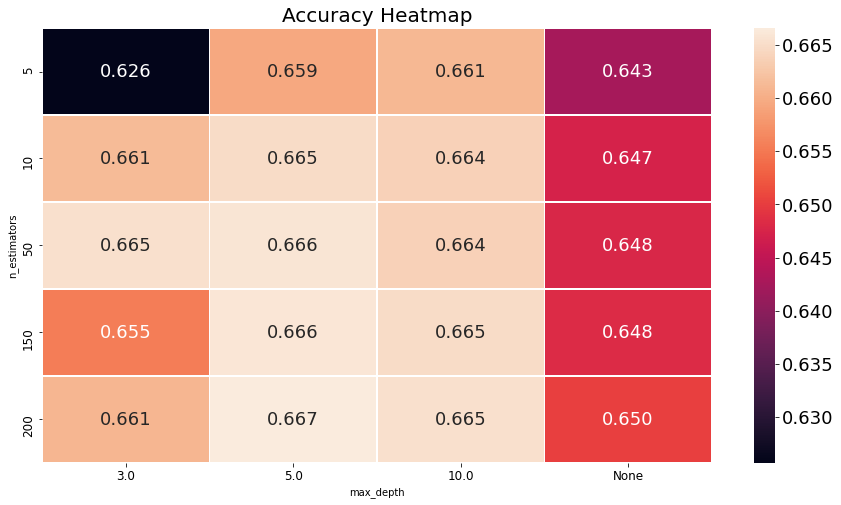

In [77]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

In [78]:
%%time
# Building model with optimal parameters
r_forest = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)
r_forest.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, r_forest.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  66.94
Wall time: 1.07 s


In [79]:
# Evaluating the model on the test set
r_forest_pred = r_forest.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, r_forest_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  67.16


#### Gradient Tree Boosting Classifier

In [80]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier(random_state = 0)

g_boost_params = [{'n_estimators':[5, 10, 50, 150, 200]}]
g_boost_grid = GridSearchCV(g_boost, g_boost_params, cv=10)
g_boost_grid.fit(X_train, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

Wall time: 2min 2s


GradientBoostingClassifier(n_estimators=150, random_state=0)

In [81]:
g_boost_average_score

array([0.65931542, 0.65998946, 0.6641161 , 0.66596937, 0.66462193])

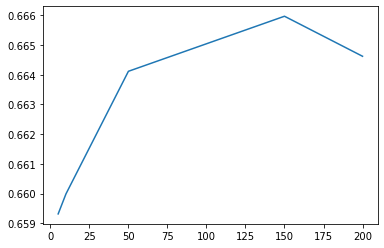

In [82]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

In [83]:
%%time
# Building model with optimal parameters
g_boost = GradientBoostingClassifier(n_estimators=150, random_state=0)
g_boost.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, g_boost.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  68.14
Wall time: 5.51 s


In [84]:
# Evaluating the model on the test set
g_boost_pred = g_boost.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, g_boost_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  67.33


## Investigating the effect of  feature scaling on Trees algorithm

### Standard Scaler

In [85]:
# Feature scaling the matrix of features
X_scaler = StandardScaler()
X_SS = X_scaler.fit_transform(X_train)

The normalization teschnique used is z-score normalization which modifies the data to have a mean of 0 and a standard deviation of 1 thus making the aggregate data have the properties of a normal distribution.

##### Decision Tree Model

In [86]:
d_tree_grid.fit(X_SS, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, random_state=0)

In [87]:
d_tree_average_score

array([0.65182178, 0.65763143, 0.653506  , 0.64238964])

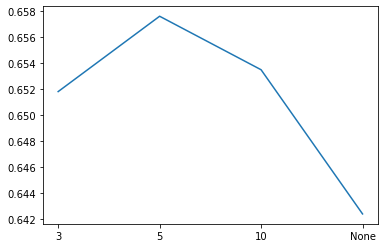

In [88]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

##### Building the Random Forest Model

In [89]:
r_forest_grid.fit(X_SS, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)

In [90]:
r_forest_average_score

array([0.62571772, 0.66133584, 0.66529384, 0.65544231, 0.66083015,
       0.65948221, 0.66487325, 0.66588385, 0.6659683 , 0.66655774,
       0.6610007 , 0.66369494, 0.6637789 , 0.6646215 , 0.66546347,
       0.64247509, 0.64727449, 0.64811673, 0.6485374 , 0.65022132])

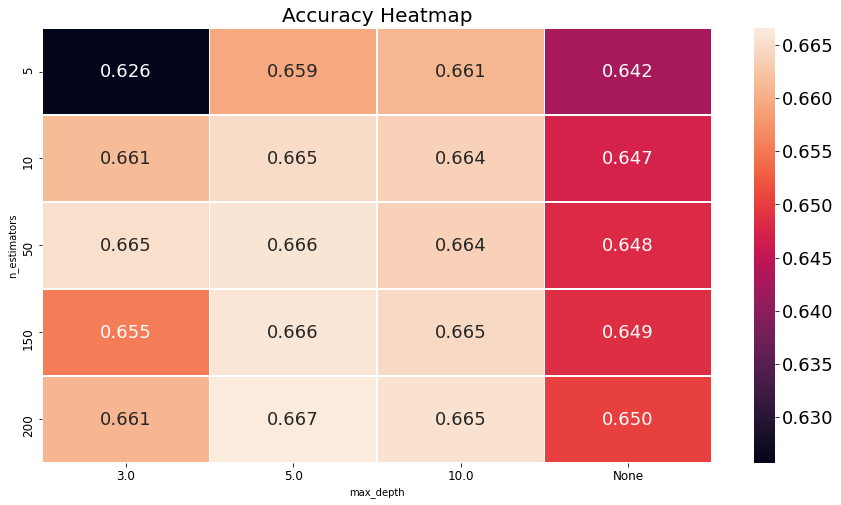

In [91]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

##### Gradient Tree Boosting Model

In [92]:
g_boost_grid.fit(X_SS, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

GradientBoostingClassifier(n_estimators=150, random_state=0)

In [93]:
g_boost_average_score

array([0.65931542, 0.65998946, 0.6641161 , 0.66596937, 0.66462193])

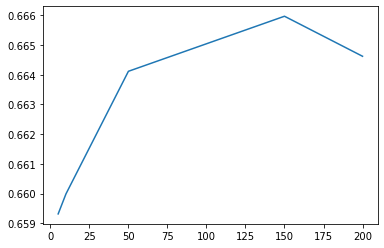

In [94]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

### MinMax Scaler

In [95]:
# Feature scaling the matrix of features
X_scaler = MinMaxScaler()
X_MM = X_scaler.fit_transform(X_train)

The normalization teschnique used is z-score normalization which modifies the data to have a mean of 0 and a standard deviation of 1 thus making the aggregate data have the properties of a normal distribution.

##### Decision Tree Model

In [96]:
d_tree_grid.fit(X_MM, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, random_state=0)

In [97]:
d_tree_average_score

array([0.65182178, 0.65763143, 0.653506  , 0.64230539])

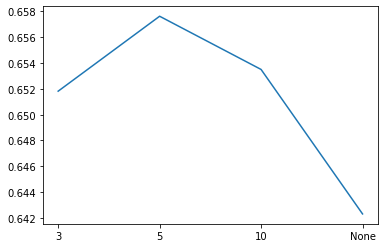

In [98]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

##### Building the Random Forest Model

In [99]:
r_forest_grid.fit(X_MM, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)

In [100]:
r_forest_average_score

array([0.62571772, 0.66133584, 0.66529384, 0.65544231, 0.66083015,
       0.65948221, 0.66487325, 0.66588385, 0.6659683 , 0.66655774,
       0.66100077, 0.66377911, 0.66369466, 0.66495827, 0.66529497,
       0.64255919, 0.64735859, 0.64786414, 0.64836905, 0.65022146])

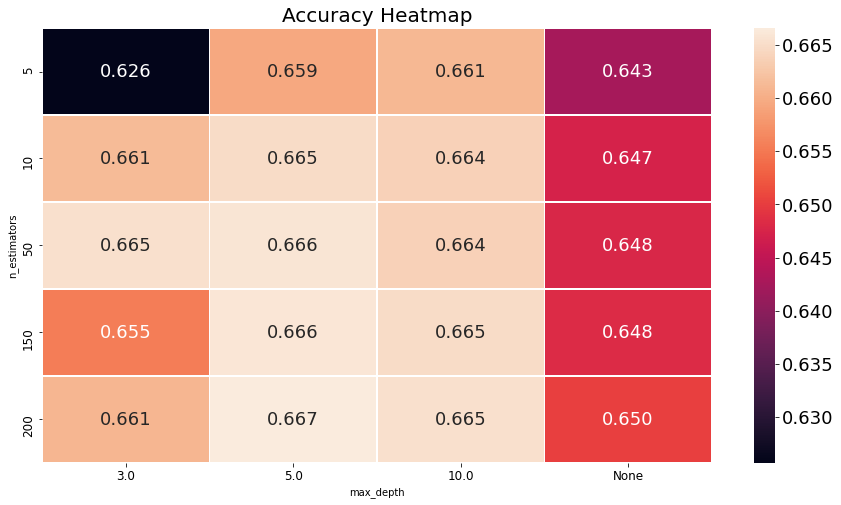

In [101]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

##### Gradient Tree Boosting Model

In [102]:
g_boost_grid.fit(X_MM, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

GradientBoostingClassifier(n_estimators=150, random_state=0)

In [103]:
g_boost_average_score

array([0.65931542, 0.65998946, 0.6641161 , 0.66596937, 0.66462193])

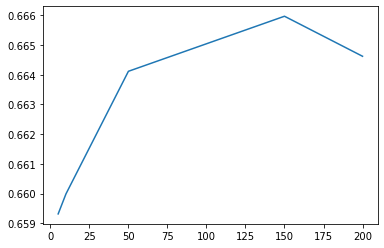

In [104]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

### Robust Scaler

In [105]:
# Feature scaling the matrix of features
X_scaler = StandardScaler()
X_RS = X_scaler.fit_transform(X_train)

The normalization teschnique used is z-score normalization which modifies the data to have a mean of 0 and a standard deviation of 1 thus making the aggregate data have the properties of a normal distribution.

##### Decision Tree Model

In [106]:
d_tree_grid.fit(X_RS, y_train)
d_tree_average_score = d_tree_grid.cv_results_['mean_test_score'].astype(float)
result = d_tree_grid.cv_results_
d_tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, random_state=0)

In [107]:
d_tree_average_score

array([0.65182178, 0.65763143, 0.653506  , 0.64238964])

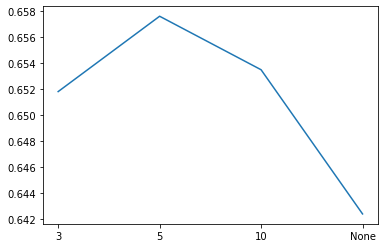

In [108]:
plt.figure()
sns.lineplot(x=['3', '5', '10', 'None'], y=d_tree_average_score)
plt.show()

##### Building the Random Forest Model

In [109]:
r_forest_grid.fit(X_RS, y_train)
r_forest_average_score = r_forest_grid.cv_results_['mean_test_score'].astype(float)
r_forest_grid.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=0)

In [110]:
r_forest_average_score

array([0.62571772, 0.66133584, 0.66529384, 0.65544231, 0.66083015,
       0.65948221, 0.66487325, 0.66588385, 0.6659683 , 0.66655774,
       0.6610007 , 0.66369494, 0.6637789 , 0.6646215 , 0.66546347,
       0.64247509, 0.64727449, 0.64811673, 0.6485374 , 0.65022132])

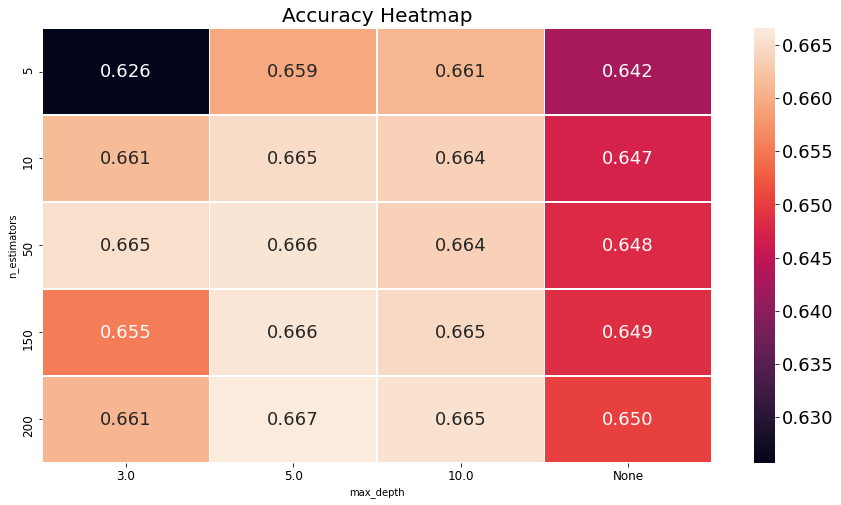

In [111]:
plot_data = pd.DataFrame(r_forest_grid.cv_results_['params'])
plot_data.fillna("None", inplace = True)
plot_data['accuracy'] = r_forest_average_score
pivot = plot_data.pivot_table(values='accuracy',index='n_estimators',columns='max_depth')
plot_heatmap(pivot, 'Accuracy Heatmap')

##### Gradient Tree Boosting Model

In [112]:
g_boost_grid.fit(X_RS, y_train)
g_boost_average_score = g_boost_grid.cv_results_['mean_test_score'].astype(float)
result = g_boost_grid.cv_results_
g_boost_grid.best_estimator_

GradientBoostingClassifier(n_estimators=150, random_state=0)

In [113]:
g_boost_average_score

array([0.65931542, 0.65998946, 0.6641161 , 0.66596937, 0.66462193])

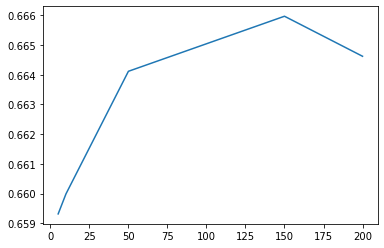

In [114]:
plt.figure()
sns.lineplot(x=[5, 10, 50, 150, 200], y=g_boost_average_score)
plt.show()

# Question 2

### Naive Bayes Classifier

### Base Model

In [115]:
dataset.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,...,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_No,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,43.524881,-80.233743,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,8,44.410713,-79.686306,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,43.656591,-79.379358,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,8,45.345665,-75.763912,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


In [116]:
# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [118]:
%%time

# Fitting the Classification Model
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb_params = [{'var_smoothing':[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}]
nb_grid = GridSearchCV(nb, nb_params, cv=10)
nb_grid.fit(X_train, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 798 ms


GaussianNB(var_smoothing=0.1)

In [119]:
nb_average_score

array([0.37875625, 0.4047738 , 0.55860423, 0.6085387 , 0.6577997 ])

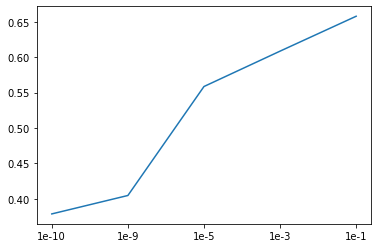

In [120]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [121]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  65.82
Wall time: 52 ms


In [122]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.44


### Improving Model Computation Time

#### Method 1: Dropping the Reporting_PHU_City column

In [123]:
dataset2.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,1,0,0,1,0,0,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,0,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,0,1,0,0,1,0
3,1,43.656591,-79.379358,0,0,0,1,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,0,1,0,0,1,2


In [124]:
# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [126]:
%%time

# Fitting the Classification Model
nb_grid.fit(X_train, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 842 ms


GaussianNB(var_smoothing=0.1)

In [127]:
nb_average_score

array([0.37875625, 0.4047738 , 0.55860423, 0.6085387 , 0.6577997 ])

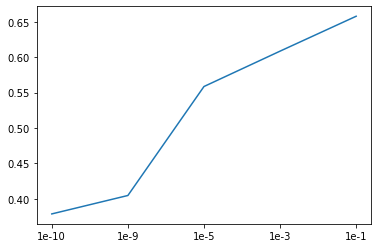

In [128]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [129]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  65.82
Wall time: 48 ms


In [130]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.44


#### Method 2: Aggregating categories in the columns

In [131]:
dataset3.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_OTHER,Reporting_PHU_City_2,Reporting_PHU_City_3,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,1,0,0,1,0,0,1,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,1,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,1,0,1,0,1,0
3,1,43.656591,-79.379358,0,0,1,0,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,1,0,0,0,1,2


In [132]:
# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [134]:
%%time

# Fitting the Classification Model
nb_grid.fit(X_train, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 833 ms


GaussianNB(var_smoothing=0.1)

In [135]:
nb_average_score

array([0.37875625, 0.4047738 , 0.55860423, 0.6085387 , 0.6577997 ])

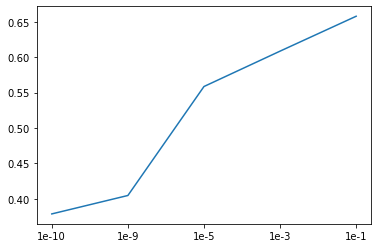

In [136]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [137]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  65.82
Wall time: 33 ms


In [138]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  65.44


### Improving the model by feature scaling

##### Standard Scaler

In [139]:
X_scaler = StandardScaler()
X_SS = X_scaler.fit_transform(X_train)
X_SS_test = X_scaler.transform(X_test)
nb_grid.fit(X_SS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [140]:
nb_average_score

array([0.35627172, 0.35837695, 0.4028372 , 0.48510151, 0.54210172])

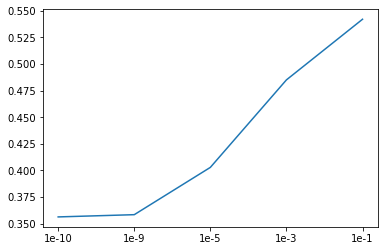

In [141]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [142]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_SS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_SS)), 2))

Training Set Evaluation
Accuracy:  54.89
Wall time: 39 ms


In [143]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_SS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  56.48


##### MinMax Scaler

In [144]:
X_scaler = MinMaxScaler()
X_MMS = X_scaler.fit_transform(X_train)
X_MMS_test = X_scaler.transform(X_test)
nb_grid.fit(X_MMS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [145]:
nb_average_score

array([0.36401937, 0.37050319, 0.51027546, 0.57249758, 0.59784534])

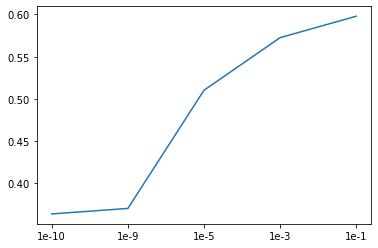

In [146]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [147]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.001)
nb.fit(X_MMS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_MMS)), 2))

Training Set Evaluation
Accuracy:  57.7
Wall time: 33.1 ms


In [148]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_MMS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  58.27


##### Robust Scaler

In [149]:
X_scaler = RobustScaler()
X_RS = X_scaler.fit_transform(X_train)
X_RS_test = X_scaler.transform(X_test)
nb_grid.fit(X_RS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=1e-05)

In [150]:
nb_average_score

array([0.4909949 , 0.53208283, 0.60205658, 0.53140965, 0.33310882])

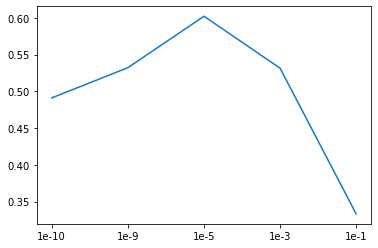

In [151]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [152]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=1e-05)
nb.fit(X_RS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_RS)), 2))

Training Set Evaluation
Accuracy:  60.73
Wall time: 38 ms


In [153]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_RS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  59.68


The Naive Bayes classifier performs better without feature scalling

## Kaggle Competition

### Using Aggregated column categories and Randon Forest Model

In [154]:
# Importing the test data
train_data = data.copy()
test_data = pd.read_csv("covid_test.csv")
ids = test_data['id']

In [155]:
test_data.head()

,id,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,0,80s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358
1,1,80s,MALE,NO KNOWN EPI LINK,Toronto,Yes,43.656591,-79.379358
2,2,40s,FEMALE,OB,Stratford,Yes,43.368662,-81.001913
3,3,30s,MALE,NO KNOWN EPI LINK,Mississauga,NaN,43.647471,-79.708893
4,4,60s,MALE,NO KNOWN EPI LINK,London,NaN,42.981468,-81.254016


In [156]:
# checking for missing values in test_data columns
for column in test_data.columns[1:]:
    print(column, "-", test_data[column].isna().sum())

Age_Group - 0
Client_Gender - 0
Case_AcquisitionInfo - 0
Reporting_PHU_City - 0
Outbreak_Related - 2288
Reporting_PHU_Latitude - 0
Reporting_PHU_Longitude - 0


In [157]:
# filling missing values in outbreak related with NO
test_data["Outbreak_Related"].fillna("No", inplace=True)   

In [158]:
test_data['Age_Group'].replace(["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],[0,1,2,3,4,5,6,7,8], inplace = True)
test_data.head()

,id,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,0,7,FEMALE,MISSING INFORMATION,Toronto,No,43.656591,-79.379358
1,1,7,MALE,NO KNOWN EPI LINK,Toronto,Yes,43.656591,-79.379358
2,2,3,FEMALE,OB,Stratford,Yes,43.368662,-81.001913
3,3,2,MALE,NO KNOWN EPI LINK,Mississauga,No,43.647471,-79.708893
4,4,5,MALE,NO KNOWN EPI LINK,London,No,42.981468,-81.254016


In [159]:
train_data["Client_Gender"].replace(['UNSPECIFIED', 'GENDER DIVERSE'], 'OTHER', inplace = True)
test_data["Client_Gender"].replace(['UNSPECIFIED', 'GENDER DIVERSE'], 'OTHER', inplace = True)

In [160]:
train_data["Case_AcquisitionInfo"].replace(['TRAVEL', 'UNSPECIFIED EPI LINK'], 'OTHER', inplace = True)
test_data["Case_AcquisitionInfo"].replace(['TRAVEL', 'UNSPECIFIED EPI LINK'], 'OTHER', inplace = True)

In [161]:
train_data["Reporting_PHU_City"].replace(City_Class1, 1, inplace = True)
train_data["Reporting_PHU_City"].replace(City_Class2, 2, inplace = True)
train_data["Reporting_PHU_City"].replace(City_Class3, 3, inplace = True)
test_data["Reporting_PHU_City"].replace(City_Class1, 1, inplace = True)
test_data["Reporting_PHU_City"].replace(City_Class2, 2, inplace = True)
test_data["Reporting_PHU_City"].replace(City_Class3, 3, inplace = True)

In [162]:
df = pd.get_dummies(train_data.iloc[:,:-1], drop_first=True, columns = cats)
df["Outcome1"] = train_data["Outcome1"]
train_data = df

train_data.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_OTHER,Reporting_PHU_City_2,Reporting_PHU_City_3,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,1,0,0,1,0,0,1,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,1,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,1,0,1,0,1,0
3,1,43.656591,-79.379358,0,0,1,0,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,1,0,0,0,1,2


In [163]:
test_data = pd.get_dummies(test_data.iloc[:,1:], drop_first=True, columns = cats)
test_data.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_OTHER,Reporting_PHU_City_2,Reporting_PHU_City_3,Outbreak_Related_Yes
0,7,43.656591,-79.379358,0,0,1,0,0,0,0,0,0
1,7,43.656591,-79.379358,1,0,0,1,0,0,0,0,1
2,3,43.368662,-81.001913,0,0,0,0,1,0,0,1,1
3,2,43.647471,-79.708893,1,0,0,1,0,0,0,0,0
4,5,42.981468,-81.254016,1,0,0,1,0,0,1,0,0


In [164]:
missing_columns = [column for column in train_data.columns[:-1] if not column in test_data.columns]
missing_columns

[]

In [165]:
for column in missing_columns:
    test_data[column] = 0

In [166]:
test_data.shape

(3713, 12)

In [167]:
test_data = test_data[train_data.columns[:-1]]

In [168]:
# Separating the dataset into matrix of features and target'
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values

X_test = test_data.iloc[:,:].values

In [169]:
%%time
# Building model with optimal parameters
r_forest = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)
r_forest.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, r_forest.predict(X_train)), 2))

Training Set Evaluation
Accuracy:  69.88
Wall time: 545 ms


In [170]:
# Evaluating the model on the test set
r_forest_pred = r_forest.predict(X_test)
r_forest_pred

array([2, 2, 1, ..., 2, 2, 2], dtype=int64)

In [171]:
result = pd.DataFrame(columns=['id','Outcome1'])
result['id'] = ids
result['Outcome1'] = r_forest_pred

result.set_index(keys='id', inplace=True)
result['Outcome1'].replace([0,1,2], ["Resolved", "Not Resolved", "Fatal"], inplace = True)
result.to_csv('submission.csv')

In [172]:
result

,Outcome1
id,
0,Fatal
1,Fatal
2,Not Resolved
3,Resolved
4,Not Resolved
...,...
3708,Fatal
3709,Not Resolved
3710,Fatal
